# Install Pytorch, Torchvision

In [ ]:
#!pip install -U torch torchvision
#!pip install git+https://github.com/facebookresearch/fvcore.git
#import torch, torchvision
#torch.__version__

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 14.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 5.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=180edf5578cfe5839da9ac7fb1402e

# Install Detectron2

In [ ]:
#!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
#!pip install -e detectron2_repo

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 960 kB/s 
     |████████████████████████████████| 49 kB 2.8 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=5cbc24e7ce546f623879770ee7aa823f676bf1731a71e5c81321988cf4c5bf06
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore


# Import

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train with COCO dataset

In [ ]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter

import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/detectron')
!ls

Mounted at /content/gdrive
coco_test  coco_train  coco_validate  output


Register the tools dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("tools", {}, "coco_train/labels.json", "coco_train/data")

In [ ]:
tools_metadata = MetadataCatalog.get("tools")
dataset_dicts = DatasetCatalog.get("tools")

WARNING [11/09 00:11:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/09 00:11:52 d2.data.datasets.coco]: Loaded 4411 images in COCO format from coco_train/labels.json


In [ ]:
register_coco_instances("test_tools", {}, "coco_test/labels.json", "coco_test/data")
test_tools_metadata = MetadataCatalog.get("test_tools")
test_dataset_dicts = DatasetCatalog.get("test_tools")

WARNING [11/09 00:11:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/09 00:11:53 d2.data.datasets.coco]: Loaded 1103 images in COCO format from coco_test/labels.json


Visualising annotations of random training set to verify imported dataset

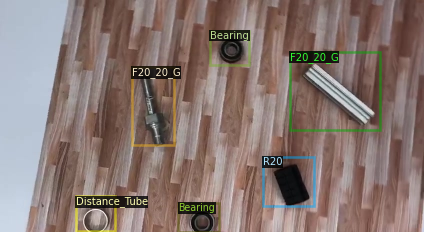

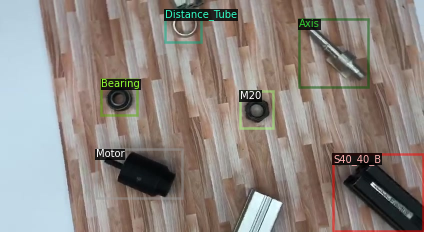

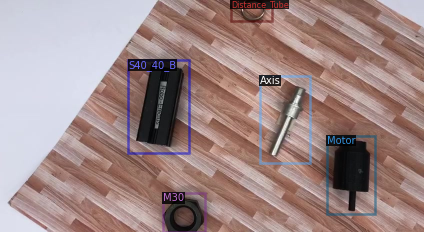

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tools_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator 
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

Train model with coco pretrained faster rcnn.
Tune hyper parameters


In [ ]:
!rm ./output/metrics.json

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("tools",)
#cfg.DATASETS.TEST = ()
cfg.DATASETS.TEST = ("test_tools",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14    # 1 more to include super category "Defect"
cfg.MODEL.RETINANET.NUM_CLASSES = 14    # 1 more to include super category "Defect"
cfg.TEST.EVAL_PERIOD = 20

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[11/09 00:12:19 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_59f53c.pkl: 228MB [00:08, 27.4MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (126, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (126,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}


[11/09 00:12:31 d2.engine.train_loop]: Starting training from iteration 0
WARNING [11/09 00:13:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/09 00:13:15 d2.data.datasets.coco]: Loaded 1103 images in COCO format from coco_test/labels.json
[11/09 00:13:15 d2.data.build]: Distribution of instances among all 14 categories:
|  category   | #instances   |   category    | #instances   |  category  | #instances   |
|:-----------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
|   Defect    | 0            |     Axis      | 630          |  Bearing   | 655          |
| Bearing_Box | 492          | Distance_Tube | 781          |  F20_20_B  | 470          |
|  F20_20_G   | 542          |   S40_40_B    | 472          |  S40_40_G  | 602          |
|    Motor    | 580          |      M20      | 493          |    M30     | 474          |
|   M20_100   | 594          |      R20      | 537          |   

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

experiment_metrics

[{'data_time': 0.007254321999994318,
  'eta_seconds': 184.01329211850435,
  'iteration': 19,
  'loss_box_reg': 0.3875390440225601,
  'loss_cls': 1.7022144198417664,
  'lr': 0.00039962,
  'num_foreground': 404.5,
  'time': 2.2717690385000537,
  'total_loss': 2.170895591378212},
 {'data_time': 0.006573389000038787,
  'eta_seconds': 138.25904031450142,
  'iteration': 39,
  'loss_box_reg': 0.10376662760972977,
  'loss_cls': 0.9745150506496429,
  'lr': 0.0007992199999999999,
  'num_foreground': 402.0,
  'time': 2.2665416445000233,
  'total_loss': 1.0547042563557625},
 {'data_time': 0.006499125499999536,
  'eta_seconds': 92.61575687950108,
  'iteration': 59,
  'loss_box_reg': 0.07128530740737915,
  'loss_cls': 0.5577539801597595,
  'lr': 0.00119882,
  'num_foreground': 364.0,
  'time': 2.2562111965000327,
  'total_loss': 0.6315269265323877},
 {'data_time': 0.006284675500012327,
  'eta_seconds': 47.45195504700018,
  'iteration': 79,
  'loss_box_reg': 0.10661933571100235,
  'loss_cls': 0.49289

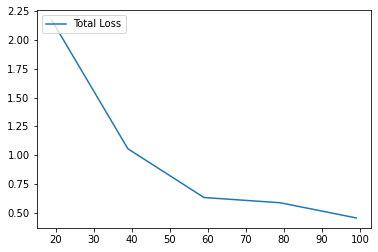

In [ ]:
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.legend(['Total Loss'], loc='upper left')
plt.show()

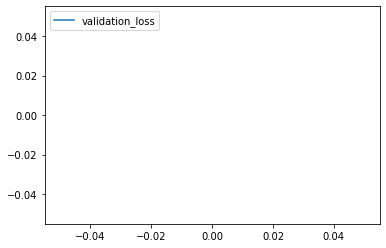

In [ ]:
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['validation_loss'], loc='upper left')
plt.show()

# Load trained model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model (Any confidence level that is >= 50% will show)
cfg.DATASETS.TEST = ("tools", )
predictor = DefaultPredictor(cfg)

# Testing

Then we test using testing dataset

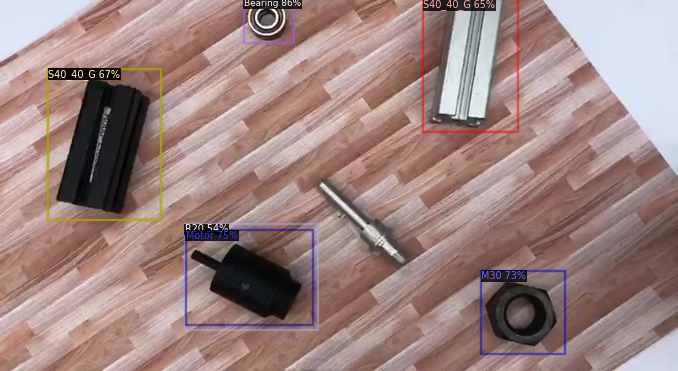

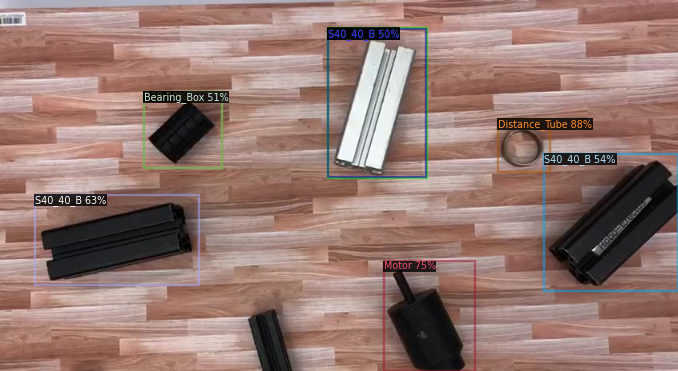

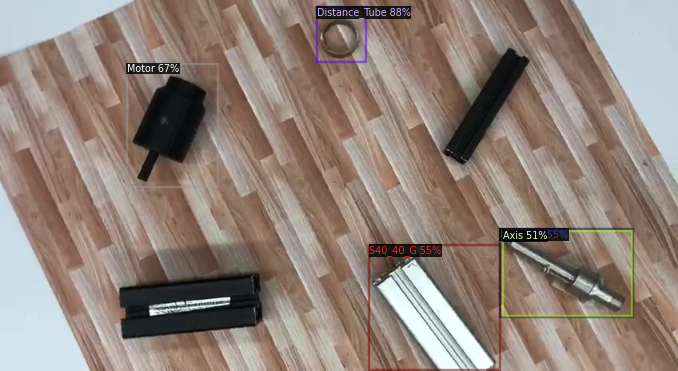

In [ ]:
for d in random.sample(test_dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_tools_metadata, 
                   scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("test_tools", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "test_tools")

inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [11/09 00:16:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/09 00:16:35 d2.data.datasets.coco]: Loaded 1103 images in COCO format from coco_test/labels.json
[11/09 00:16:35 d2.data.common]: Serializing 1103 elements to byte tensors and concatenating them all ...
[11/09 00:16:35 d2.data.common]: Serialized dataset takes 0.61 MiB
[11/09 00:16:35 d2.evaluation.evaluator]: Start inference on 1103 images
[11/09 00:16:43 d2.evaluation.evaluator]: Inference done 11/1103. 0.5400 s / img. ETA=0:10:28
[11/09 00:16:48 d2.evaluation.evaluator]: Inference done 20/1103. 0.5405 s / img. ETA=0:10:42
[11/09 00:16:54 d2.evaluation.evaluator]: Inference done 30/1103. 0.5424 s / img. ETA=0:10:17
[11/09 00:16:59 d2.evaluation.evaluator]: Inference done 40/1103. 0.5422 s / img. ETA=0:10:03
[11/09 00:17:05 d2.evaluation.evaluator]: Inference done 50/1103. 0.5427 s / img. ETA=0:09:53
[11/09 00:17:10 d2.evaluation.evaluator]: Inf

OrderedDict([('bbox',
              {'AP': 33.853502341559306,
               'AP-Axis': 18.759877369670868,
               'AP-Bearing': 43.870058207406636,
               'AP-Bearing_Box': 38.498376955537026,
               'AP-Defect': nan,
               'AP-Distance_Tube': 47.22547721756957,
               'AP-F20_20_B': 0.1254125412541254,
               'AP-F20_20_G': 23.223043965319548,
               'AP-M20': 21.929327411890267,
               'AP-M20_100': 31.225488532457234,
               'AP-M30': 41.49499271296798,
               'AP-Motor': 45.780214560272526,
               'AP-R20': 38.90427799741243,
               'AP-S40_40_B': 40.862215219962614,
               'AP-S40_40_G': 48.19676774855015,
               'AP50': 53.88624106556278,
               'AP75': 38.1649201194956,
               'APl': 33.028555199300556,
               'APm': 19.988364888912265,
               'APs': 0.0})])

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.53,fps:1.88
